# LeNet5 Analog Training Example
Training the LeNet5 neural network with MNIST dataset and the Analog SGD optimizer simulated on the analog resistive random-access memory with soft bounds (ReRam) device.

<a href="https://colab.research.google.com/github/IBM/aihwkit/blob/master/notebooks/analog_training_LeNet5_plot.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>


## Why Analog AI

In-memory computing hardware increases the speed and energy-efficiency needed for the next steps in AI. Analog AI delivers radical performance improvements by combining compute and memory in a single device, eliminating the von Neumann bottleneck. 
Based on von Neumann architecture, conventional computers perform calculations by repeatedly transferring data between the memory and processor. These trips require time and energy, negatively impacting performance. This is known as the von Neumann bottleneck. 

<img src="https://github.com/IBM/aihwkit/blob/master/notebooks/img/processing-unit-and-computional-memory.png?raw=1"  alt="Drawing" style="width=50px;"/> 
<img src="https://github.com/IBM/aihwkit/blob/master/notebooks/img/processing-unit-and-conventional-memory.png?raw=1" alt="Drawing" style="width=50px;"> 

By leveraging the physical properties of in-memory computing devices (example: Phase Change Memory or PCM), computation happens at the same place where the data is stored, drastically reducing energy consumption. Because there is no movement of data, tasks can be performed in a fraction of the time and with much less energy. This is different from a conventional computer, where the data is transferred from the DRAM memory to the CPU every time a computation is done. For example, moving 64 bits of data from DRAM to CPU consumes 1-2nJ, which is 10,000–2,000,000 times more energy than is dissipated in a PCM device performing a multiplication operation (1-100fJ). Also, PCM does not consume power when the devices are inactive, and the data will be retained for up to 10 years even when the power supply is turned off. 

## The physics behind PCM

 With PCM, when an electrical pulse is applied to the material, it changes the [conductance](https://energyeducation.ca/encyclopedia/Electrical_conductance) of the device by switching the material between amorphous and crystalline phases. A low electrical pulse will make the PCM device more crystalline (less resistance), this pulse can be repeatedly applied to gradually decrease the device resistance. On the other hand, the material change from the crystalline phase (low resistance) to the amorphouse phase (high resistance) is quite abrupt and requires a high electrical pulse to RESET the device. Therefore, it is possible to records the states as a continuum of values between the two extremes, instead of encoding 0 or 1 like in the digital world.

PCM devices have the ability to store synaptic weights in their analog conductance state. When PCM devices are arranged in a crossbar configuration, it allows to perform an analog matrix-vector multiplication in a single time step, exploiting the advantages of multi-level storage capability and Kirchhoff’s circuits laws. The figure below shows how PCM devices are arranged in a crossbar configuration. 
<center><img src="https://github.com/IBM/aihwkit/blob/master/notebooks/img/pcm-array.png?raw=1" style="width:30%; height:30%"/></center> 

This crossbar configuration is also referred to as an Analog tile. The PCM devices at each crossbard crosspoint are also referred to as Resitive Processing Units or RPU units as shown in the figure below:

<center><img src="https://github.com/IBM/aihwkit/blob/master/notebooks/img/pcm_rpu_unit.png?raw=1" style="width:30%; height:30%"/></center> 

Besides PCM, other devices or materials can be used as resistive units or RPUs in the crossbar configuration. Examples include Resistive Random Access Memory (RRAM), Electro chemical Random Access Memory (ECRAM), Magnetic RAM (MRAM), photonics, etc. The weights of neural network are stored in the RPU units as confuctance values that are programmed on the chip through as series of electrical pulses. The conductance behavior changes from one analog device to another. 


## Analog AI and Neural Networks

In deep learning inference, data propagation through multiple layers of a neural network involves a sequence of matrix multiplications, as each layer can be represented as a matrix of synaptic weights. On an Analog chip, these weights are stored in the conductance states of resistive devices such as PCM. The devices are arranged in crossbar arrays, creating an artificial neural network where all matrix multiplications are performed in-place in an analog manner. This structure allows inference to be performed using little energy with high areal density of synapses. An in-memory computing chip typically consists of multiple crossbar arrays of memory devices that communicate with each other (see figure below). A neural network layer can be implemented on (at least) one crossbar, in which the weights of that layer are stored in the charge or conductance state of the memory devices at the crosspoints.

<center><img src="https://github.com/IBM/aihwkit/blob/master/notebooks/img/analog_Dnn.png?raw=1" style="width:60%; height:60%"/></center> 



## IBM Analog Hardware Acceleration Kit (AIHWKIT)

The IBM Analog Hardware Acceleration Kit (AIHWKIT) is an open source Python toolkit for exploring and using the capabilities of in-memory computing devices such as PCM in the context of artificial intelligence. 
The pytorch integration consists of a series of primitives and features that allow using the toolkit within PyTorch. 

The github repository can be found at: https://github.com/IBM/aihwkit

To learn more about Analog AI and the harware befind it, refer to this webpage: https://analog-ai-demo.mybluemix.net/hardware


### Installing the AIHWKIT
The first thing to do is to install the AIHHKIT and dependencies in your environment. The preferred way to install this package is by using the Python package index (please uncomment this line to install in your environment if not previously installed):

In [1]:
# To install the cpu-only enabled kit, uncommend the line below
#!pip install aihwkit

# To install the gpu enabled wheel, use the commands below
#!wget https://aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud/aihwkit-0.8.0+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl 
#!pip install aihwkit-0.8.0+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


In [2]:
# Install livelossplot to visualize the training losses live
!pip install livelossplot --quiet


## LeNet5 Neural Network Examples

In this notebook we will use the AIHWKIT to train a LeNet5 inspired analog network, as studied in the paper: https://www.frontiersin.org/articles/10.3389/fnins.2017.00538/full

<img src="https://github.com/IBM/aihwkit/blob/master/notebooks/img/LeNet5_animation.png?raw=1" style="width:40%; height:40%"/> 

The architecture of the LeNet5 network is shown below:

<img src="https://github.com/IBM/aihwkit/blob/master/notebooks/img/LeNet.png?raw=1" style="width:40%; height:40%"/> 

The network will be trained using the MNIST dataset, a collection of images representing the digits 0 to 9. 

From Kaggle: "MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike."

[Read more.](https://www.kaggle.com/c/digit-recognizer)

<img src="https://github.com/IBM/aihwkit/blob/master/notebooks/img/MnistExamples.png?raw=1" style="width:40%; height:40%"/> 


## Analog layers
If the library was installed correctly, you can use the following snippet for creating an analog layer and predicting the output. In the code snippet below AnalogLinea is the Analog equivalent to Linear PyTorch layer.

In [3]:
from torch import Tensor
from aihwkit.nn import AnalogLinear

model = AnalogLinear(2, 2)
model(Tensor([[0.1, 0.2], [0.3, 0.4]]))

tensor([[-0.1739, -0.5419],
        [-0.0421, -0.5136]], grad_fn=<AddBackward0>)

## RPU Configuration
Now that the package is installed and running, we can start working on creating the LeNet5 network.

AIHWKIT offers different Analog layers that can be used to build a network, including AnalogLinear and AnalogConv2d which will be the main layers used to build the present network. 
In addition to the standard input that are expected by the PyTorch layers (in_channels, out_channels, etc.) the analog layers also expect an rpu_config input which defines various settings of the RPU tile or the Analog hardware.

Through the rpu_config parameters, the user can specify many of the hardware specs such as: device used in the cross-point array, bits used by the ADC/DAC converters, noise values and many other parameters. 

Additional details on the RPU configuration can be found at https://aihwkit.readthedocs.io/en/latest/using_simulator.html#rpu-configurations

For this particular use case, we will define two RPU configurations that we will use later in the code. The first rpu_config uses an ideal device which is linear and symmetric in the conductance changes. The second rpu_config will use a realistic Resistive Random Access Memory (ReRAM) device with its non-idealities. We will use this two configurations to highlight their impacts on network accuracy.


### Using RPU configuration of an ideal Analog device
Analog devices, when employed to implement synaptic weights of a neural network, need to meet certain specifications for the network performance to be comparable to that of a floating-point software implementation. Such specifications applicable to training a neural network on the MNIST classification benchmark were derived in [Gokmen & Vlasov, Front. Neurosci. 2016](https://www.frontiersin.org/articles/10.3389/fnins.2016.00333/full). The specifications may vary for different networks, datasets, and optimizers, and the AIHWKIT provides the capability to experiment with them. 

The ideal analog device is represented in the code snippet below using SingleRPUConfig(device=ConstantStepDevice()).
This RPU configuration simulates a fictitious analog device array with idealized specifications, inspired by those listed in [Gokmen & Vlasov, Front. Neurosci. 2016](https://www.frontiersin.org/articles/10.3389/fnins.2016.00333/full). This device has an ideal linear increase of conductance with a number of pulses. It includes device-to-device variations as well as pulse-to-pulse fluctuations of conductance. The global asymmetry between positive and negative update and device-to-device asymmetry terms are set to zero. The number of steps was increased by ten-fold (to 10000 states) compared with that of Gokmen & Vlasov. 

<img src="https://github.com/IBM/aihwkit/blob/master/notebooks/img/idealizedDevice.png?raw=1" style="width:40%; height:40%"/> 

In [4]:
def create_rpu_config_1():

    from aihwkit.simulator.configs import SingleRPUConfig
    from aihwkit.simulator.configs.devices import ConstantStepDevice

    rpu_config=SingleRPUConfig(device=ConstantStepDevice())

    return rpu_config

### Using RPU configuration of a realistic ReRAM device
Resistive random-access memory (ReRAM) is a non-volatile memory technology with tuneable conductance states that can be used for in-memory computing. The conductance change of a ReRAM device is bidirectional, that is, it is possible to both increase and decrease its conductance incrementally by applying suitable electrical pulses. This capability can be exploited to implement the backpropagation algorithm. The change of conductance in oxide ReRAM is attributed to change in the configuration of the current conducting filament which consists of oxygen vacancies in a metal oxide film. 

The simulated ReRAM device is based on the of [Gong et al](https://www.nature.com/articles/s41467-018-04485-1). This device was fabricated with hafnium oxide as the metal oxide switching layer. The preset captures the experimentally measured response of this device to 1000 positive and 1000 negative pulses (shown in Figure 3a), including the pulse-to-pulse fluctuations. The movement of the oxygen vacancies in response to electrical signals has a probabilistic nature and it emerges as inherent randomness in conductance changes. Realistic device-to-device variability is also included in the preset to appropriately simulate the behavior of an array of such devices. 

<img src="https://github.com/IBM/aihwkit/blob/master/notebooks/img/reram.png?raw=1" style="width:40%; height:40%"/> 

In [5]:
def create_rpu_config_2():

    from aihwkit.simulator.presets import ReRamSBPreset

    rpu_config=ReRamSBPreset()

    return rpu_config

We can now use the defined rpu_config as input of the network model:

In [6]:
from torch.nn import Tanh, MaxPool2d, LogSoftmax, Flatten
from aihwkit.nn import AnalogConv2d, AnalogLinear, AnalogSequential

def create_analog_network(rpu_config):
    
    channel = [16, 32, 512, 128]
    model = AnalogSequential(
        AnalogConv2d(in_channels=1, out_channels=channel[0], kernel_size=5, stride=1,
                        rpu_config=rpu_config),
        Tanh(),
        MaxPool2d(kernel_size=2),
        AnalogConv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=5, stride=1,
                        rpu_config=rpu_config),
        Tanh(),
        MaxPool2d(kernel_size=2),
        Tanh(),
        Flatten(),
        AnalogLinear(in_features=channel[2], out_features=channel[3], rpu_config=rpu_config),
        Tanh(),
        AnalogLinear(in_features=channel[3], out_features=10, rpu_config=rpu_config),
        LogSoftmax(dim=1)
    )

    return model

## Analog Optimizer 

We will use the cross entropy criteria to calculate the loss and the Stochastic Gradient Descent (SGD) as optimizer:

In [7]:
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()


from aihwkit.optim import AnalogSGD

def create_analog_optimizer(model):
    """Create the analog-aware optimizer.

    Args:
        model (nn.Module): model to be trained

    Returns:
        Optimizer: created analog optimizer
    """
    
    optimizer = AnalogSGD(model.parameters(), lr=0.01) # we will use a learning rate of 0.01 as in the paper
    optimizer.regroup_param_groups(model)

    return optimizer

## Training the network

We can now write the train function which will optimize the network over the MNIST train dataset. The train_step function will take as input the images to train on, the model to train and the criterion and optimizer to train with:

In [8]:
from torch import device
from aihwkit.simulator.rpu_base import cuda


DEVICE = device('cuda' if cuda.is_compiled() else 'cpu')
print('Running the simulation on: ', DEVICE)

def train_step(train_data, model, criterion, optimizer):
    """Train network.

    Args:
        train_data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
        optimizer (Optimizer): analog model optimizer

    Returns:
        train_dataset_loss: epoch loss of the train dataset
    """
    total_loss = 0
    predicted_ok = 0
    total_images = 0

    model.train()

    for images, labels in train_data:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        # Add training Tensor to the model (input).
        output = model(images)
        loss = criterion(output, labels)

        # Run training (backward propagation).
        loss.backward()

        # Optimize weights.
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        total_loss += loss.item() * images.size(0)
        predicted_ok += torch.sum(predicted == labels.data)
        total_images += labels.size(0)
        
        
    train_loss = total_loss / len(train_data.dataset)
    train_accuracy = predicted_ok.float()/len(train_data.dataset)*100
    train_error = (1-predicted_ok.float()/len(train_data.dataset))*100

    return train_loss, train_error, train_accuracy

Running the simulation on:  cuda


Since training can be quite time consuming it is nice to see the evolution of the training process by testing the model capabilities on a set of images that it has not seen before (test dataset). So we write a test_step function:

In [9]:
def test_step(validation_data, model, criterion):
    """Test trained network

    Args:
        validation_data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss

    Returns: 
        test_dataset_loss: epoch loss of the train_dataset
        test_dataset_error: error of the test dataset
        test_dataset_accuracy: accuracy of the test dataset
    """
    total_loss = 0
    predicted_ok = 0
    total_images = 0

    model.eval()

    for images, labels in validation_data:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        pred = model(images)
        loss = criterion(pred, labels)
        total_loss += loss.item() * images.size(0)

        _, predicted = torch.max(pred.data, 1)
        total_images += labels.size(0)
        predicted_ok += (predicted == labels).sum().item()

    test_dataset_loss = total_loss / len(validation_data.dataset)
    test_dataset_accuracy = predicted_ok/len(validation_data.dataset)*100
    test_dataset_error = (1-predicted_ok/total_images)*100

    return test_dataset_loss, test_dataset_error, test_dataset_accuracy

To reach satisfactory accuracy levels, the train_step will have to be repeated mulitple time so we will implement a loop over a certain number of epochs:

In [11]:
from livelossplot import PlotLosses

def training_loop(model, criterion, optimizer, train_data, validation_data, epochs=15, print_every=1):
    """Training loop.

    Args:
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
        optimizer (Optimizer): analog model optimizer
        train_data (DataLoader): Validation set to perform the evaluation
        validation_data (DataLoader): Validation set to perform the evaluation
        epochs (int): global parameter to define epochs number
        print_every (int): defines how many times to print training progress

    Returns:
        nn.Module, Optimizer, Tuple: model, optimizer, and a tuple of
            lists of train losses, validation losses, and test error
    """

    liveloss = PlotLosses()

    # Train model
    for epoch in range(0, epochs):
        logs = {}
        # Train_step
        train_loss, train_error, train_acc = train_step(train_data, model, criterion, optimizer)

        if epoch % print_every == (print_every - 1):
            # Validate_step
            with torch.no_grad():
                valid_loss, valid_error, valid_acc = test_step(validation_data, model, criterion)

            print(f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train error: {train_error:.2f}%\t'
                  f'Valid error: {valid_error:.2f}%\t'
                  f'Train accuracy: {train_acc:.2f}%\t'
                  f'Valid accuracy: {valid_acc:.2f}%\t')
            
            logs['loss'] = train_loss
            logs['val_loss'] = valid_loss
            
            logs['accuracy'] = train_acc.detach().cpu()
            logs['val_accuracy'] = valid_acc

            logs['error'] = train_error.detach().cpu()
            logs['val_error'] = valid_error

            liveloss.update(logs)
            liveloss.send()
                 

We will now download the MNIST dataset and prepare the images for the training and test:

In [12]:
import os
from torchvision import datasets, transforms
PATH_DATASET = os.path.join('data', 'DATASET')
os.makedirs(PATH_DATASET, exist_ok=True)

def load_images():
    """Load images for train from torchvision datasets."""

    transform = transforms.Compose([transforms.ToTensor()])
    train_set = datasets.MNIST(PATH_DATASET, download=True, train=True, transform=transform)
    test_set = datasets.MNIST(PATH_DATASET, download=True, train=False, transform=transform)
    train_data = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
    test_data = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False)

    return train_data, test_data

### Training using the idealized rpu configuration
Put together all the code above to train the network on the idealized analog device. 

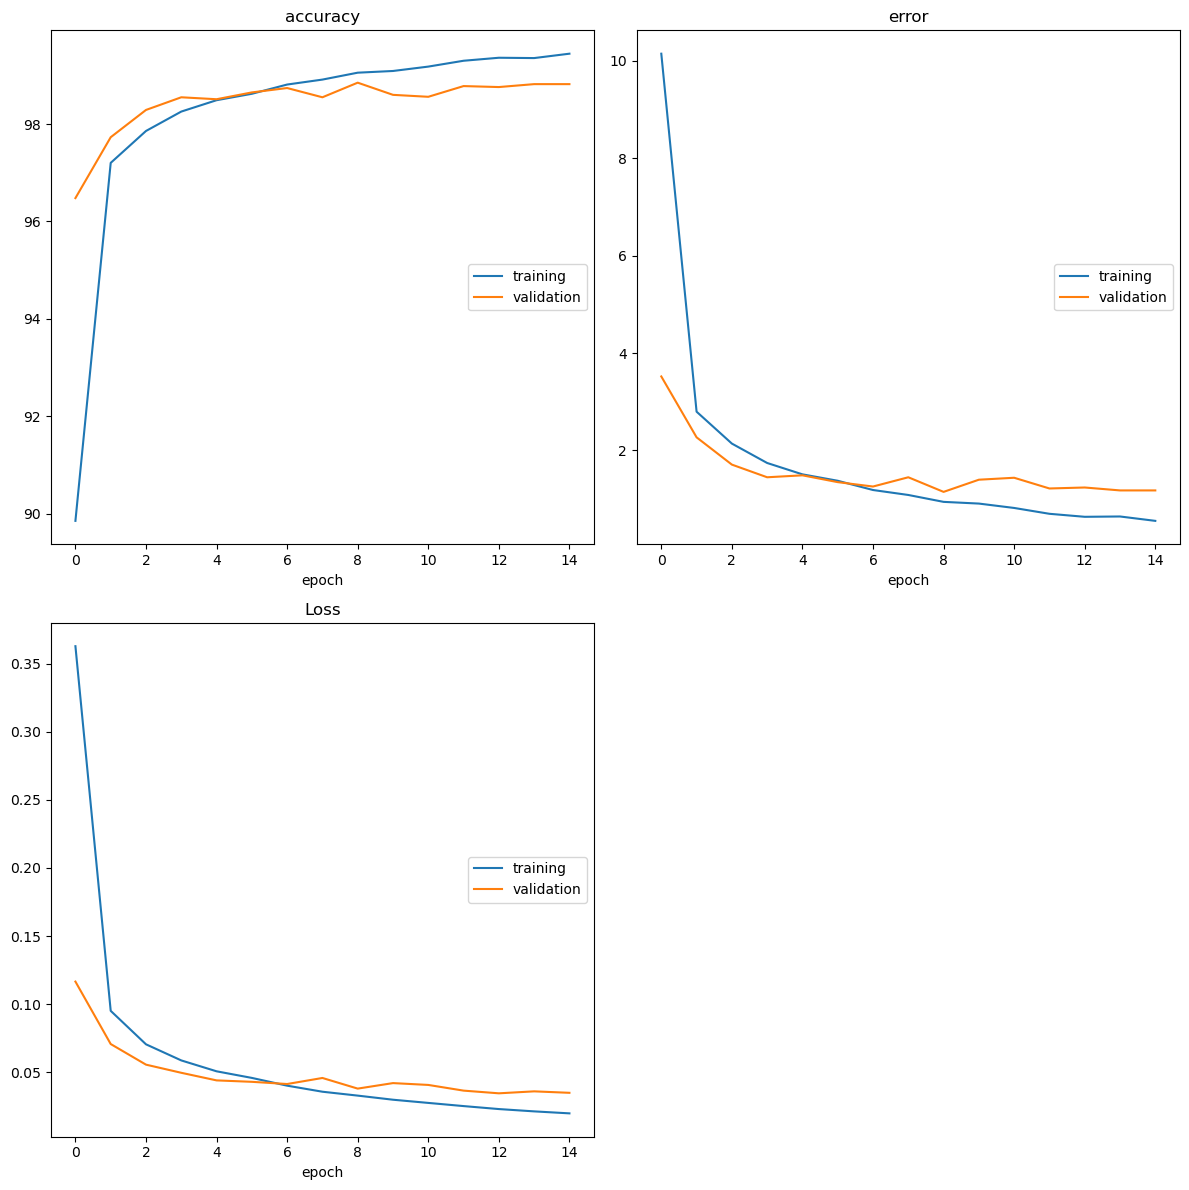

accuracy
	training         	 (min:   89.853, max:   99.445, cur:   99.445)
	validation       	 (min:   96.480, max:   98.850, cur:   98.820)
error
	training         	 (min:    0.555, max:   10.147, cur:    0.555)
	validation       	 (min:    1.150, max:    3.520, cur:    1.180)
Loss
	training         	 (min:    0.020, max:    0.363, cur:    0.020)
	validation       	 (min:    0.035, max:    0.117, cur:    0.035)


In [13]:
import torch

torch.manual_seed(1)

#load the dataset
train_data, test_data = load_images()

#create the rpu_config
rpu_config = create_rpu_config_1()

#create the model
model = create_analog_network(rpu_config).to(DEVICE)

#define the analog optimizer
optimizer = create_analog_optimizer(model)

training_loop(model, criterion, optimizer, train_data, test_data)

### Training using the Analog ReRam device
As shown by the code above Analog AI is capable of achieving high accuracy when using standard optimizer and algorithm with ideal devices. Now let's see what happens if standard SGD with the BP algorithm is used with a non-ideal device such as ReRAM

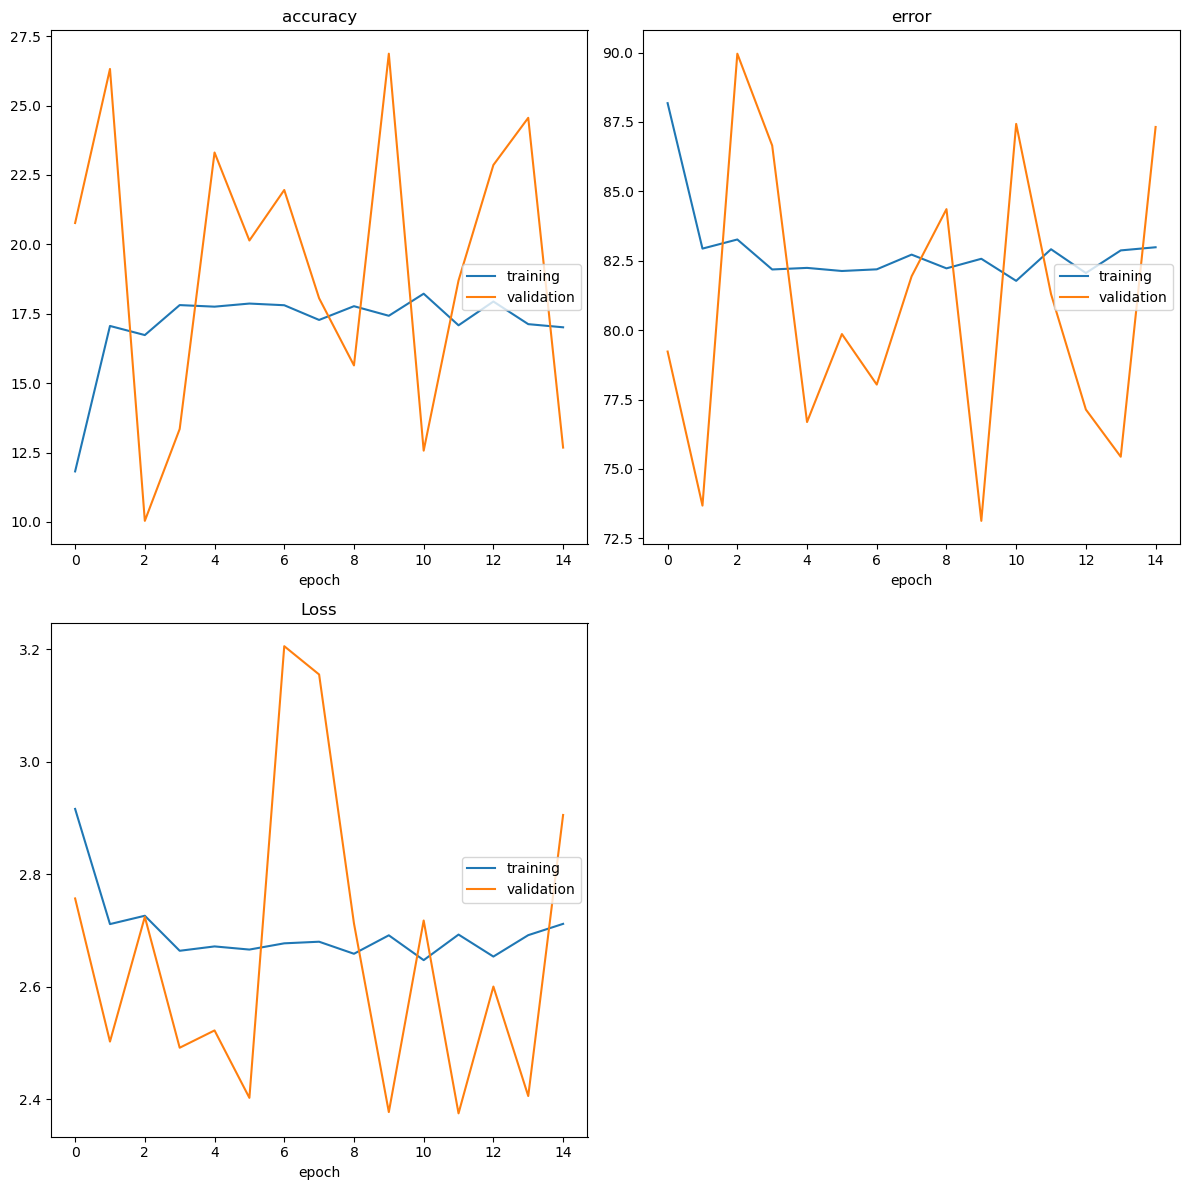

accuracy
	training         	 (min:   11.822, max:   18.223, cur:   17.013)
	validation       	 (min:   10.040, max:   26.870, cur:   12.680)
error
	training         	 (min:   81.777, max:   88.178, cur:   82.987)
	validation       	 (min:   73.130, max:   89.960, cur:   87.320)
Loss
	training         	 (min:    2.647, max:    2.916, cur:    2.712)
	validation       	 (min:    2.375, max:    3.206, cur:    2.905)


In [14]:
import torch

torch.manual_seed(1)

#load the dataset
train_data, test_data = load_images()

#create the rpu_config
rpu_config = create_rpu_config_2()

#create the model
model = create_analog_network(rpu_config).to(DEVICE)

#define the analog optimizer
optimizer = create_analog_optimizer(model)

training_loop(model, criterion, optimizer, train_data, test_data)

In this case the same network configuration with same parameters is perfoming much worse than when using the ideal device, which underscores the importance of innovating not only at a device/circuit level but also at algorithmic level.

In the [next notebook](https://github.com/IBM-AI-Hardware-Center/aihwkit-notebooks/blob/main/analog_training_LeNet5_TT.ipynb) we will show how the Tiki-Taka algorithm, specifically designed for non-volatile memory and analog computing, is capable of achieving high performance also with non-ideal devices.